# Borrows from feature engineering code present on Kaggle from Chris Deloitte

Personal code is in XGBoost model and some of the PCA-feature creation

# Loading from saved csv files

Preloads data from expanded datasets present on Kaggle

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
from biopandas.pdb import PandasPdb
from biopandas.mmcif import PandasMmcif

train = pd.read_csv ('train.csv')
holdout = pd.read_csv('holdout.csv')
df = pd.read_csv ('input/all_train_data.csv')

bad = [f for f in df.PDB.unique() if len(f)>4]
bad += ['1LVE', '2IMM', '2RPN', '1BKS', '1BLC', '1D5G', '1KDX', '1OTR', '3BN0', '3D3B', '3HHR', '3O39']
bad += ['3BDC','1AMQ','1X0J','1TPK','1GLM','1RHG','3DVI','1RN1','1QGV'] 
bad += ['1SVX','4E5K'] 

aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}
aa_map_2 = {x:y for x,y in zip(np.sort(list(aa_map.values())),np.arange(20))}
aa_map_2['X'] = 20

# https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties
aa_props = pd.read_csv('downloaded_csv/aminoacids.csv').set_index('Letter')
PROPS = ['Molecular Weight', 'Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 
         'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']

C:\Users\richa\anaconda3\envs\KaggleComptetion_2022\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Feature Engineering - Run below

In [2]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata

import torch, esm
token_map = {'L': 0, 'A': 1, 'G': 2, 'V': 3, 'S': 4, 'E': 5, 'R': 6, 'T': 7, 'I': 8, 'D': 9, 'P': 10, 
         'K': 11, 'Q': 12, 'N': 13, 'F': 14, 'Y': 15, 'M': 16, 'H': 17, 'W': 18, 'C': 19}
t_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
t_model.eval()  # disables dropout for deterministic results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model.to(device)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

# Runs protein sequences through Facebook ESM model

In [3]:
PCA_CT = 16 # random sample size per protein to fit PCA with
all_pdb = [f for f in df.PDB.unique() if f not in bad]
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
all_pdb_embed_pool = np.zeros((len(all_pdb)+1,1280))
all_pdb_embed_local = []
all_pdb_embed_tmp = []

from scipy.special import softmax 
from scipy.stats import entropy
all_pdb_prob = []

# EXTRACT TRANSFORMER EMBEDDINGS FOR TRAIN AND TEST WILDTYPES
print('Extracting embeddings from proteins...')
for i,p in enumerate(all_pdb+['TEST']):
    
    # WILDTYPE SEQUENCE
    print(p,', ',end='')
    if p=='TEST': seq = base
    else: seq = df.loc[df.PDB==p,'sequence'].iloc[0]
                    
    # EXTRACT EMBEDDINGS, MUTATION PROBABILITIES, ENTROPY
    data = [("protein1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = t_model(batch_tokens, repr_layers=[33])
    

    logits = (results['logits'].detach().cpu().numpy()[0,].T)[4:24,1:-1]
    all_pdb_prob.append(softmax(logits,axis=0))
    
    results = results["representations"][33].detach().cpu().numpy()
    
    # SAVE EMBEDDINGS
    all_pdb_embed_local.append(results)
    all_pdb_embed_pool[i,] = np.mean( results[0,:,:],axis=0 )
    
    # TEMPORARILY SAVE LOCAL MUTATION EMBEDDINGS
    tmp = df.loc[df.PDB==p,'position'].unique()
    if p=='TEST': tmp = np.random.choice(range(20,200),PCA_CT,replace=False)
    if len(tmp)>PCA_CT: tmp = np.random.choice(tmp,PCA_CT,replace=False)
    for j in tmp: all_pdb_embed_tmp.append( results[0,j,:] )
        
    del batch_tokens, results
    gc.collect(); torch.cuda.empty_cache()

all_pdb_embed_tmp = np.stack(all_pdb_embed_tmp)

Extracting embeddings from proteins...
1A5E , 1A7C , 1AAR , 1AG2 , 1AKK , 1ANK , 1APS , 1AYI , 1AZP , 1B0O , 1B10 , 1BNI , 1BP2 , 1BU4 , 1C2R , 1C9O , 1CDC , 1CSP , 1CYC , 1DIV , 1FRD , 1FTG , 1FXA , 1G6P , 1H0X , 1HFY , 1HFZ , 1HNG , 1IGV , 1IHB , 1IMQ , 1JY0 , 1K5U , 1K9Q , 1LZ1 , 1M7T , 1MGR , 1MJC , 1N18 , 1O1U , 1OIA , 1P2P , 1POH , 1QLP , 1QM0 , 1QQV , 1REI , 1RGG , 1RIL , 1RRO , 1SHF , 1SHG , 1STN , 1TEN , 1TTG , 1UBQ , 1UWO , 1VII , 1W4E , 1W4H , 1Y4Y , 1Y9X , 2A36 , 2AFG , 2AKY , 2BJD , 2DVV , 2HBB , 2HMB , 2HPR , 2IFB , 2K3K , 2K7K , 2KYC , 2MMX , 2N53 , 2OUO , 2RN2 , 2TRX , 3DVF , 3ECU , 3F6R , 3S92 , 4BJX , 4GWT , 4HXJ , 4JZ4 , 4LYZ , 4YEE , 4YEF , 5C0Z , 5EMZ , 5T43 , 5TR5 , 1A43 , 1AJ3 , 1AM7 , 1ARR , 1AYF , 1BFM , 1BPI , 1BTA , 1BVC , 1CHK , 1DIL , 1DKT , 1FKJ , 1G6N , 1H56 , 1H7M , 1HME , 1HTI , 1HUE , 1IO2 , 1IOB , 1ITM , 1KCQ , 1KFW , 1LS4 , 1MBG , 1MSI , 1N88 , 1NVO , 1OH0 , 1ONC , 1PDO , 1PFL , 1QND , 1RIS , 1ROP , 1RTB , 1RX4 , 1SUP , 1TIT , 1TUP , 1UZC , 1VQB , 1W

# Runs PCA on ESM features

In [4]:
from sklearn.decomposition import PCA
pca_pool = PCA(n_components=0.99)
pca_embeds = pca_pool.fit_transform(all_pdb_embed_pool.astype('float32'))
pca_local = PCA(n_components=0.99)
pca_local.fit(all_pdb_embed_tmp.astype('float32'))
pdb_map = {x:y for x,y in zip(all_pdb,range(len(all_pdb)))}
pdb_map['kaggle'] = len(all_pdb)
del all_pdb_embed_tmp
_ = gc.collect()

In [5]:
# FEATURE ENGINEER FUNCTION
def get_new_row(atom_df, j, row):
    ##################
    # ATOM_DF - IS PDB FILE'S ATOM_DF
    # J - IS RESIDUE NUMBER WHICH IS TRAIN CSV POSITION PLUS OFFSET
    # ROW - IS ROW FROM DOWNLOADED TRAIN CSV
    ##################
        
    dd = None
    tmp = atom_df.loc[(atom_df.residue_number==j)].reset_index(drop=True)
    prev = atom_df.loc[(atom_df.residue_number==j-1)].reset_index(drop=True)
    post = atom_df.loc[(atom_df.residue_number==j+1)].reset_index(drop=True)
    
    # FEATURE ENGINEER
    if len(tmp)>0:
        
        
        # GET MUTANT EMBEDDINGS
        data = [("protein1", row.mutant_seq)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad():
            results = t_model(batch_tokens, repr_layers=[33]) 
        results = results["representations"][33].cpu().numpy()
        mutant_local = pca_local.transform(results[:1,row.position,:])[0,]
        mutant_pool = np.mean( results[:1,:,:],axis=1 )
        mutant_pool = pca_pool.transform(mutant_pool)[0,]   
    
        # MUTATION AND POSITION
        dd = {}
        dd['WT'] = row.wildtype
        dd['WT2'] = tmp.residue_name.map(aa_map)[0]
        dd['MUT'] = row.mutation
        dd['position'] = row.position
        dd['relative_position'] = row.position / len(row.sequence)

        
        # TRANSFORMER ESM EMBEDDINGS
        wt_local = pca_local.transform(all_pdb_embed_local[pdb_map[row.PDB]][:1,row.position,:])[0,]
        wt_pool = pca_embeds[pdb_map[row.PDB],]
        
        for kk in range(wt_pool.shape[0]):
            dd[f'pca_pool_{kk}'] = mutant_pool[kk] - wt_pool[kk]
            if kk>=wt_local.shape[0]: continue
            dd[f'pca_wt_{kk}'] = wt_local[kk]
            dd[f'pca_mutant_{kk}'] = mutant_local[kk]
            dd[f'pca_local_{kk}'] = mutant_local[kk] - wt_local[kk]
            
        # TARGETS AND SOURCES
        dd['ddG'] = row.ddG
        dd['dTm'] = row.dTm
        dd['pdb'] = row.PDB
        dd['source'] = row.source
        
        
        
        
        del batch_tokens, results, mutant_local, mutant_pool, wt_local, wt_pool
        gc.collect(); torch.cuda.empty_cache()
    
    
    
    return dd

In [6]:
pdb = None
rows = []
offsets = []

for index,row in df.iterrows():
    if row.PDB in bad: continue
        
    # READ PDB FILE WHICH CONTAINS MORE INFO ABOUT PROTEIN
    first = False
    if row.PDB != pdb:
        pdb = row.PDB
        
        try:
            nan_value = np.isnan(row.CIF)
        except:
            nan_value = False
            
            
        if pd.isnull (row.CIF) == False:
            atom_df = PandasMmcif().read_mmcif(f'input/train-wildtypes-af/cif/{row.CIF}-model_v3.cif')
            
            atom_df = atom_df.df['ATOM']
            atom_df = atom_df.rename({'label_seq_id':'residue_number','label_comp_id':'residue_name'},axis=1)
            atom_df = atom_df.rename({'Cartn_x':'x_coord','Cartn_y':'y_coord','Cartn_z':'z_coord'},axis=1)
            atom_df = atom_df.rename({'B_iso_or_equiv':'b_factor','label_atom_id':'atom_name'},axis=1)
        else:
            atom_df = PandasPdb().read_pdb(f'downloaded_pdb/{row.PDB}.pdb')
            atom_df = atom_df.df['ATOM']
        first = True

    
    
    # VERY IMPORTANT - ALIGN SEQUENCES
    # THE RESIDUE NUMBERS IN PDB FILES DONT MATCH THE POSTION NUMBERS IN CSV FILE!
    tmp = atom_df.drop_duplicates(['residue_name','residue_number']).sort_values('residue_number')
    tmp = tmp.iloc[20:36].reset_index(drop=True)
    d = (tmp.residue_number.diff()!=1.0).sum()
    if d>1: print(f'=> ERROR missing consecutive amino acids in PDB file {row.PDB}')
    tmp['letter'] = tmp.residue_name.map(aa_map)  
    pdb_seq = (''.join( tmp.letter.values ))
    csv_seq = df.loc[df.PDB==row.PDB,'sequence'].values[0]
    i = csv_seq.find(pdb_seq)
    if i==-1: print('=> ERROR cannot find PDB sequence in CSV sequence for {row.PDB}')
    x = tmp.loc[0,'residue_number']
    offset = (x-i)-1
    if first: 
        print(f'{row.PDB} PDB residue_number equals {offset} added to position in CSV')
        dd = {}
        dd['pdb'] = row.PDB
        dd['offset'] = offset
        offsets.append(dd)
    
    # FEATURE ENGINEER
    j = row.position + offset

    
    dd = get_new_row(atom_df, j, row)
    if dd is not None:
        rows.append(dd)

1A5E PDB residue_number equals 0 added to position in CSV
1A7C PDB residue_number equals 1 added to position in CSV
1AAR PDB residue_number equals 0 added to position in CSV
1AG2 PDB residue_number equals 123 added to position in CSV
1AKK PDB residue_number equals 0 added to position in CSV
1ANK PDB residue_number equals 0 added to position in CSV
1APS PDB residue_number equals 0 added to position in CSV
1AYI PDB residue_number equals 0 added to position in CSV
1AZP PDB residue_number equals 0 added to position in CSV
1B0O PDB residue_number equals 1 added to position in CSV
1B10 PDB residue_number equals 124 added to position in CSV
1BNI PDB residue_number equals 2 added to position in CSV
1BP2 PDB residue_number equals 0 added to position in CSV
1BU4 PDB residue_number equals 0 added to position in CSV
1C2R PDB residue_number equals 0 added to position in CSV
1C9O PDB residue_number equals 0 added to position in CSV
1CDC PDB residue_number equals 3 added to position in CSV
1CSP PDB r

2ABD PDB residue_number equals 0 added to position in CSV
2C9Q PDB residue_number equals 0 added to position in CSV
2DRI PDB residue_number equals 0 added to position in CSV
2GNQ PDB residue_number equals 18 added to position in CSV
2IN9 PDB residue_number equals 0 added to position in CSV
2LTB PDB residue_number equals 499 added to position in CSV
2LZM PDB residue_number equals 0 added to position in CSV
2MPC PDB residue_number equals 3 added to position in CSV
2PTL PDB residue_number equals 0 added to position in CSV
2RLK PDB residue_number equals 0 added to position in CSV
2SPZ PDB residue_number equals 0 added to position in CSV
2VY0 PDB residue_number equals 33 added to position in CSV
2WQG PDB residue_number equals 0 added to position in CSV
3BLS PDB residue_number equals 3 added to position in CSV
3G1G PDB residue_number equals 150 added to position in CSV
3MBP PDB residue_number equals 0 added to position in CSV
3PG0 PDB residue_number equals 1 added to position in CSV
3S4M PDB

In [7]:
# IF WILD TYPE GROUP HAS FEWER THAN THIS MANY MUTATION ROWS REMOVE THEM
EXCLUDE_CT_UNDER = 25

# CREATE EXTERNAL TRAIN DATAFRAME
train = pd.DataFrame(rows)
train = train.loc[train.WT == train.WT2].reset_index(drop=True)
print('Train plus Holdout data shape', train.shape )
train['ct'] = train.groupby('pdb').WT.transform('count')
train = train.loc[train.ct>EXCLUDE_CT_UNDER].reset_index(drop=True)
train = train.drop(['WT2','ct'],axis=1)
print('Data shape after removing small mutation groups', train.shape )

Train plus Holdout data shape (6463, 605)
Data shape after removing small mutation groups (4944, 604)


In [8]:
# RANK NORMALIZE ddG AND dTm TARGETS SO ALL CAN BE MIXED TOGETHER
train['target'] = 0.5
for g in train.pdb.unique():
    target = 'dTm'
    tmp = train.loc[train.pdb==g,'dTm']
    if tmp.isna().sum()>len(tmp)/2: target = 'ddG'
    train.loc[train.pdb==g,'target'] =\
        rankdata(train.loc[train.pdb==g,target])/len(train.loc[train.pdb==g,target])
train.head()

,WT,MUT,position,relative_position,pca_pool_0,pca_wt_0,pca_mutant_0,pca_local_0,pca_pool_1,pca_wt_1,...,pca_local_147,pca_pool_148,pca_wt_148,pca_mutant_148,pca_local_148,ddG,dTm,pdb,source,target
0,A,G,30,0.306122,-0.055940,4.996624,5.054200,0.057575,-0.065350,1.992188,...,0.039041,-0.003289,0.283277,0.124473,-0.158804,-1.650718,NaN,1APS,jin_train.csv,0.555556
1,E,D,29,0.295918,-0.082370,1.990542,1.381709,-0.608833,-0.028189,2.997503,...,-0.051596,0.000581,-0.317569,-0.213795,0.103773,-3.468900,NaN,1APS,jin_train.csv,0.148148
2,E,D,83,0.846939,-0.209216,-0.368790,-1.092276,-0.723486,-0.129485,1.625439,...,-0.070924,-0.009949,0.051874,0.047562,-0.004312,-1.507177,NaN,1APS,jin_train.csv,0.685185
3,F,L,22,0.224490,-0.161210,7.335097,6.243243,-1.091855,0.034935,2.443563,...,0.118977,-0.009636,-0.076070,-0.137524,-0.061454,-1.291866,NaN,1APS,jin_train.csv,0.814815
4,F,L,94,0.959184,-0.043828,4.095358,3.662205,-0.433154,0.045722,0.576049,...,0.118422,-0.002683,0.028025,0.057027,0.029002,-4.330144,NaN,1APS,jin_train.csv,0.074074


In [9]:
KFOLD_SOURCES = ['jin_tm.csv','jin_train.csv','jin_test.csv']
HOLDOUT_SOURCES = ['kaggle.csv']

# USE some sources TO TRAIN/VALIDATE AND other sources TO HOLDOUT VALIDATE
holdout = train.loc[train.source.isin(HOLDOUT_SOURCES)].reset_index(drop=True)
train = train.loc[train.source.isin(KFOLD_SOURCES)].reset_index(drop=True)

# LABEL ENCODE GROUPS FOR GROUP K FOLD
train['group'],_ = train.pdb.factorize()
holdout['group'],_ = holdout.pdb.factorize()

In [10]:
# IF WE TRAIN WITH ALPHA FOLD'S PDBS WE MUST INFER WITH "PLDDT = TRUE"
# KAGGLE.CSV USES ALPHA FOLD PDB, SO SET BELOW TO TRUE WHEN TRAIN WITH KAGGLE.CSV
# JIN.CSV EXTERNAL DATA USES PROTEIN DATA BANK, SO SET BELOW TO FALSE WITH JIN DATA
USE_PLDDT_INFER = False

# IF WE WISH TO TRAIN WITH MIXTURE OF ALPHA FOLD AND PROTEIN DATA BANK PDB FILES
# THEN WE CAN EXCLUDE B_COLUMN AND THEN THERE IS NO PROBLEM
USE_B_COLUMN = False

EXCLUDE = ['WT','MUT','prev','post','ddG','dTm','pdb','source','target','group','oof', 'position', 'relative_position']
FEATURES = [c for c in train.columns if c not in EXCLUDE]
print(f'We have {len(FEATURES)} features for our model:')
print( FEATURES )

We have 596 features for our model:
['pca_pool_0', 'pca_wt_0', 'pca_mutant_0', 'pca_local_0', 'pca_pool_1', 'pca_wt_1', 'pca_mutant_1', 'pca_local_1', 'pca_pool_2', 'pca_wt_2', 'pca_mutant_2', 'pca_local_2', 'pca_pool_3', 'pca_wt_3', 'pca_mutant_3', 'pca_local_3', 'pca_pool_4', 'pca_wt_4', 'pca_mutant_4', 'pca_local_4', 'pca_pool_5', 'pca_wt_5', 'pca_mutant_5', 'pca_local_5', 'pca_pool_6', 'pca_wt_6', 'pca_mutant_6', 'pca_local_6', 'pca_pool_7', 'pca_wt_7', 'pca_mutant_7', 'pca_local_7', 'pca_pool_8', 'pca_wt_8', 'pca_mutant_8', 'pca_local_8', 'pca_pool_9', 'pca_wt_9', 'pca_mutant_9', 'pca_local_9', 'pca_pool_10', 'pca_wt_10', 'pca_mutant_10', 'pca_local_10', 'pca_pool_11', 'pca_wt_11', 'pca_mutant_11', 'pca_local_11', 'pca_pool_12', 'pca_wt_12', 'pca_mutant_12', 'pca_local_12', 'pca_pool_13', 'pca_wt_13', 'pca_mutant_13', 'pca_local_13', 'pca_pool_14', 'pca_wt_14', 'pca_mutant_14', 'pca_local_14', 'pca_pool_15', 'pca_wt_15', 'pca_mutant_15', 'pca_local_15', 'pca_pool_16', 'pca_wt_16',

# XGBoost Model

In [11]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 11
SEED = 123

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.02, 
    'subsample':0.6,
    'colsample_bytree':0.2, 
    'eval_metric':'rmse',
    'objective':'reg:squarederror',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.7.1


In [12]:
%%time
importances = []
importances2 = []
oof = np.zeros(len(train))
preds = np.zeros(len(holdout))
os.system('mkdir xgb_models')

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target, train.group )):
        
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx,'target']
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    X_holdout = holdout[FEATURES]
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    dholdout = xgb.DMatrix(data=X_holdout)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'xgb_models/XGB_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    rsme = mean_squared_error(y_valid.values, oof_preds, squared=False)
    print('RSME =',rsme,'\n')
    oof[valid_idx] = oof_preds
    
    # HOLDOUT PREDS
    if len(holdout)>0:
        p = model.predict(dholdout)
        preds += p/FOLDS
    
    del dtrain, X_train, y_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
rsme = mean_squared_error(train.target.values, oof, squared=False)
print('OVERALL RSME =',rsme,'\n')

train['oof'] = oof
if len(holdout)>0: holdout['preds'] = preds

#########################
### Fold 1
### Train size 3241 Valid size 526
#########################
[0]	train-rmse:0.28727	valid-rmse:0.28757
[100]	train-rmse:0.22934	valid-rmse:0.24966
[200]	train-rmse:0.20124	valid-rmse:0.23906
[300]	train-rmse:0.18111	valid-rmse:0.23488
[400]	train-rmse:0.16482	valid-rmse:0.23141
[500]	train-rmse:0.15138	valid-rmse:0.22963
[600]	train-rmse:0.13933	valid-rmse:0.22817
[700]	train-rmse:0.12927	valid-rmse:0.22678
[800]	train-rmse:0.11974	valid-rmse:0.22621
[900]	train-rmse:0.11121	valid-rmse:0.22523
[1000]	train-rmse:0.10352	valid-rmse:0.22457
[1100]	train-rmse:0.09647	valid-rmse:0.22426
[1147]	train-rmse:0.09334	valid-rmse:0.22459
RSME = 0.22458814044245168 

#########################
### Fold 2
### Train size 3439 Valid size 328
#########################
[0]	train-rmse:0.28721	valid-rmse:0.28770
[100]	train-rmse:0.22789	valid-rmse:0.24928
[200]	train-rmse:0.19922	valid-rmse:0.23988
[300]	train-rmse:0.17937	valid-rmse:0.23507
[400]	train-rmse:0.16394	val

In [13]:
print ('Range of target values: {} to {}'.format (train.target.min(), train.target.max()))

rsme = mean_squared_error(train.target.values, oof, squared=False)
print('NORMALIZED OVERALL RSME =',rsme/(train.target.max() - train.target.min()),'\n')


Range of target values: 0.0028517110266159697 to 1.0
NORMALIZED OVERALL RSME = 0.2483334708368626 



# Validate OOF (on either dTm or ddG)

In [14]:
train['oof'] = oof

In [15]:
sp = []; sp_dtm = []; sp_ddg = []
for p in train.pdb.unique():
    tmp = train.loc[train.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.oof.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein 1APS has mutation count = 27 and target = ddG
Spearman Metric = 0.6031455816824128

Protein 1BNI has mutation count = 171 and target = ddG
Spearman Metric = 0.6135630135878629

Protein 1BU4 has mutation count = 71 and target = ddG
Spearman Metric = 0.6474104782332651

Protein 1CSP has mutation count = 50 and target = ddG
Spearman Metric = 0.7155033736365742

Protein 1FTG has mutation count = 45 and target = ddG
Spearman Metric = 0.45561448030250595

Protein 1LZ1 has mutation count = 115 and target = ddG
Spearman Metric = 0.7048351437223193

Protein 1QLP has mutation count = 36 and target = ddG
Spearman Metric = 0.12819694603851964

Protein 1RGG has mutation count = 68 and target = ddG
Spearman Metric = 0.5304841103457262

Protein 1SHF has mutation count = 70 and target = ddG
Spearman Metric = 0.46908763259001535

Protein 1STN has mutation count = 526 and target = ddG
Spearman Metric = 0.6365606255132117

Protein 1TEN has mutation count = 30 and target = ddG
Spearman Metric = 0.

In [16]:
train

,WT,MUT,position,relative_position,pca_pool_0,pca_wt_0,pca_mutant_0,pca_local_0,pca_pool_1,pca_wt_1,...,pca_wt_148,pca_mutant_148,pca_local_148,ddG,dTm,pdb,source,target,group,oof
0,A,G,30,0.306122,-0.055940,4.996624,5.054200,0.057575,-0.065350,1.992188,...,0.283277,0.124473,-0.158804,-1.650718,NaN,1APS,jin_train.csv,0.555556,0,0.358655
1,E,D,29,0.295918,-0.082370,1.990542,1.381709,-0.608833,-0.028189,2.997503,...,-0.317569,-0.213795,0.103773,-3.468900,NaN,1APS,jin_train.csv,0.148148,0,0.527402
2,E,D,83,0.846939,-0.209216,-0.368790,-1.092276,-0.723486,-0.129485,1.625439,...,0.051874,0.047562,-0.004312,-1.507177,NaN,1APS,jin_train.csv,0.685185,0,0.568944
3,F,L,22,0.224490,-0.161210,7.335097,6.243243,-1.091855,0.034935,2.443563,...,-0.076070,-0.137524,-0.061454,-1.291866,NaN,1APS,jin_train.csv,0.814815,0,0.437711
4,F,L,94,0.959184,-0.043828,4.095358,3.662205,-0.433154,0.045722,0.576049,...,0.028025,0.057027,0.029002,-4.330144,NaN,1APS,jin_train.csv,0.074074,0,0.394012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,D,H,234,0.482474,-0.016026,-1.666990,-2.138460,-0.471470,0.001807,1.208638,...,0.277984,0.365733,0.087749,NaN,-3.0,3WP4,jin_tm.csv,0.178571,49,0.368421
3763,D,N,234,0.482474,-0.008391,-1.666990,-2.105639,-0.438649,-0.002246,1.208638,...,0.277984,0.319770,0.041785,NaN,-7.5,3WP4,jin_tm.csv,0.047619,49,0.467788
3764,D,T,234,0.482474,-0.025421,-1.666990,-2.073191,-0.406201,-0.011574,1.208638,...,0.277984,0.337472,0.059488,NaN,1.0,3WP4,jin_tm.csv,0.845238,49,0.462055
3765,P,V,236,0.486598,-0.034817,0.136250,-0.698938,-0.835188,-0.009641,1.550274,...,-0.301603,-0.116410,0.185193,NaN,-10.0,3WP4,jin_tm.csv,0.011905,49,0.545352


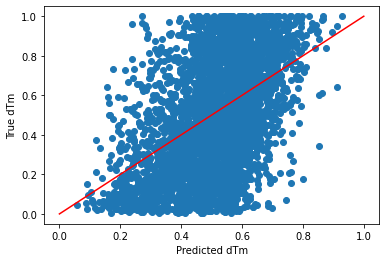

In [17]:
plt.scatter (train.oof.values, train.target.values)

x_val = np.linspace (0,1, 100)
y_val = x_val

plt.plot (x_val, y_val, color = 'r')

plt.xlabel ('Predicted dTm')
plt.ylabel ('True dTm')

plt.show()

# Validate Holdout (on either dTm or ddG)

In [18]:
holdout['preds'] = preds

In [19]:
sp = []; sp_dtm = []; sp_ddg = []
for p in holdout.pdb.unique():

    tmp = holdout.loc[holdout.pdb==p].reset_index(drop=True)
    ttarget = 'dTm'
    if tmp['dTm'].isna().sum()>len(tmp)/2: ttarget = 'ddG'
    print('Protein',p,'has mutation count =',len(tmp),'and target =',ttarget)
    r = np.abs( spearmanr(tmp.preds.values, tmp[ttarget].values).correlation )
    print('Spearman Metric =',r)
    sp.append(r)
    if ttarget=='dTm': sp_dtm.append(r)
    else: sp_ddg.append(r)
    print()

print('#'*25)
if len(sp_dtm)>0:
    print(f'Overall Spearman Metric (predicting dTm) =',np.nanmean(sp_dtm))
if len(sp_ddg)>0:
    print(f'Overall Spearman Metric (predicting ddG) =',np.nanmean(sp_ddg))

Protein GP01 has mutation count = 185 and target = dTm
Spearman Metric = 0.7451243460478248

Protein GP02 has mutation count = 211 and target = dTm
Spearman Metric = 0.9018831096395334

Protein GP06 has mutation count = 56 and target = dTm
Spearman Metric = 0.041688124347155034

Protein GP07 has mutation count = 77 and target = dTm
Spearman Metric = 0.8901940972885375

Protein GP08 has mutation count = 55 and target = dTm
Spearman Metric = 0.2770551471688091

Protein GP09 has mutation count = 30 and target = dTm
Spearman Metric = 0.868365465095227

Protein GP10 has mutation count = 84 and target = dTm
Spearman Metric = 0.863803513332965

Protein GP11 has mutation count = 46 and target = dTm
Spearman Metric = 0.0888137366040552

Protein GP12 has mutation count = 78 and target = dTm
Spearman Metric = 0.7178287376079819

Protein GP14 has mutation count = 45 and target = dTm
Spearman Metric = 0.4667632924023518

Protein GP16 has mutation count = 33 and target = dTm
Spearman Metric = 0.8436

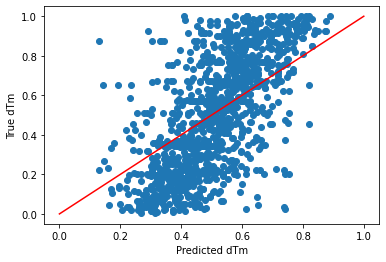

In [20]:
plt.scatter (holdout.preds.values, holdout.target.values)

x_val = np.linspace (0,1, 100)
y_val = x_val

plt.plot (x_val, y_val, color = 'r')

plt.xlabel ('Predicted dTm')
plt.ylabel ('True dTm')

plt.show()

In [21]:
print ('Overall Spearmen Metric: {}'.format (np.abs(spearmanr(holdout.preds.values, holdout.target.values).correlation)))

Overall Spearmen Metric: 0.6753485279434026


In [ ]:
print ('Overall RSME Metric: {}'.format (np.abs(spearmanr(holdout.preds.values, holdout.target.values).correlation)))